# Read through the whole tutorial before attemping to run it yourself





# Introduction to Bayesian Optimization.
### Bayesian optimization is a sequential design strategy for global optimization of black-box functions that doesn't require derivatives.

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.datasets import mnist
from sklearn.model_selection import StratifiedKFold

# Evaluation of the model
from sklearn.model_selection import KFold

MAX_EVALS = 500
N_FOLDS = 10

Using TensorFlow backend.


# Create a function to take parameters and return a compiled NN 

In [2]:
#Early stopping after 10 epochs of little decrease in our loss function.
early_stopper = EarlyStopping(patience=10)
def create_and_compile(network):
    """Network is a dictionary"""
    input_shape = (784,)
    nb_layers = network['nb_layers']
    nb_neurons = network['nb_neurons']
    activation = network['activation']
    optimizer = network['optimizer']
    #learning_rate = network['learning_rate'] TODO figure out how to add learning rate to an activation function
    #Define the type of model
    #A Sequential model, is a series of fully connected (DENSE) layers that are connected in sequence.
    model = Sequential()
    model.add(Dense(nb_neurons, activation=activation, input_shape=input_shape, name='input_layer'))
    model.add(Dropout(rate=0.2, name='dropout_input'))
    for i in range(nb_layers):
        model.add(Dense(nb_neurons, activation=activation, name='layer_{}'.format(i+1)))
        #Dropout to help avoid over-fitting
        model.add(Dropout(rate=0.2, name='dropout_{}'.format(i+1)))
    # Output layer.
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    return model

# Define our Cross validation function
This is the function that we want to use to optimize towards. Typically you "one hot encode" your target to be a vector of records, N_classes. But since the Kfolds cross validation needs to take a single volumn vector, we will one hot encode the values AFTER we split our data.

In [3]:
def cross_validate(model,X=None,y=None,num_fold=5):
    kFold = StratifiedKFold(n_splits=5)
    generator = kFold.split(X, y)
    Y_train = np_utils.to_categorical(y, 10)
    scores = []
    for val in generator:
        model.fit(x=X[val[0]], y=Y_train[val[0]], batch_size=512,
                  validation_data = [X[val[1]],Y_train[val[1]]],
                  epochs=100, verbose=0, callbacks = [early_stopper])
        scores.append(model.evaluate(X[val[1]],Y_train[val[1]]))
    return np.array(scores)[:,1].mean() # 1 is accuracy, 0 is loss

In [4]:
#Read in the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Plot the y label to see the distribution

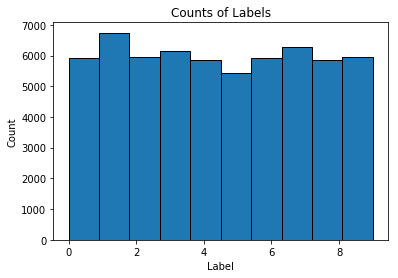

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.hist(y_train[:], edgecolor = 'k'); 
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Counts of Labels');

# Load and normalize input data

In [6]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)
Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


## Determine baseline model
Created a simple NN to get a baseline to show our improvements

In [12]:
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

start = timer()
network = {'nb_layers':1, 'nb_neurons':784, 'activation':'relu','optimizer':'adam'}
model = create_and_compile(network)
results = cross_validate(model, X_train, y_train)
train_time = timer() - start

print('The baseline score on the test set is {:.4f}.'.format(results))
print('The baseline training time is {:.4f} seconds'.format(train_time))

11996/11996 [==============================] - 1s 94us/step
The baseline score on the test set is 0.9935.
The baseline training time is 70.1870 seconds


### This is the objective function for which we are going to optimize
Essentially we are going to create, train and validate our model and check to see how close it is to 100%. 
Since we are trying to maximize our accuracy. We are taking the 1 - accuracy to get the difference. 
For example, if our model is 99% accurate, we are 1% away from 100%. We will minimze our "loss"

In [7]:
import csv
import sys
from hyperopt import STATUS_OK

def objective(params, n_folds = 5):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    sys.stdout.flush()
    start = timer()
    #When using Hyperpot to generate our lists, it creates them as floats, to we are converting them to
    #integers so that they will work on our Neural Network
    for parameter_name in ['nb_neurons', 'nb_layers']:
        params[parameter_name] = int(params[parameter_name])
    #Create and compile our network, from the parameters that the TPE choses. 
    model = create_and_compile(params)
    #Generate the accuracy of the parameters
    cv_results = cross_validate(model,X_train, y_train)
    #This allows us to keep track of how long it takes to run the 5 fold CV on our NN.
    #This is important if we need to make comprimises on speed VS accuracy.
    #The more nodes/layers that you have, the longer it takes for the NN to train/run
    run_time = timer() - start
    
    # We take 1 - our accuracy to get how far away our model is from 100% accuracy. 
    loss = 1 - cv_results

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([cv_results, params, ITERATION, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

# Pick the type of optimization algorithm

We are using the TPE which is TREE Parzen Estimator. 
    The Tree-structured Parzen Estimator builds a model by applying Bayes rule. Instead of directly representing p( y | x) instead it used Bayes rule. Which is 
$$
\begin{equation} 
p(Y|X) = \frac{(X|Y)*P(Y)}{P(X)}
\end{equation}
$$

In [1]:
from hyperopt import tpe, Trials, fmin, hp

# optimization algorithm
tpe_algorithm = tpe.suggest

# Keep track of results
bayes_trials = Trials()

### We need to use hyperopt.hp to use in our optimization
This allows the optimzation to pick the combinations.

In [2]:
# Define the search space
space = {
    'nb_layers': hp.quniform('nb_layers', 1,5, 1), #Layers from 1-5, incrementing by 1
    'nb_neurons': hp.quniform('nb_neurons', 64, 1024, 64), #NB neurons from 64-1024, incrementing by 64
    'activation': hp.choice('activation', ['relu', 'elu', 'tanh', 'sigmoid']), #Chose one of the 4 activations functions for the layers
    'optimizer': hp.choice('optimizer', ['rmsprop', 'adam', 'sgd', 'adagrad',
                      'adadelta', 'adamax', 'nadam']) #Chose one of the 7 optimizers
}

In [3]:
#Here we can see what a random sample from our space looks like
from hyperopt.pyll.stochastic import sample
sample(space)

{'activation': 'sigmoid',
 'nb_layers': 3.0,
 'nb_neurons': 192.0,
 'optimizer': 'adamax'}

# Here we are creating an output file to write the records to

In [11]:
# File to save first results
out_file = './neural_network.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['accuracy', 'params', 'iteration', 'train_time'])
of_connection.close()

# Here is where all the magic happens
We are passing the objective, the space, the optimization algo, maximum evals and the trial tracking
###### Objective: This is the custom objective function that we created 
###### space: is the search space, all of the hyper-parameters we are using to tune
###### algo: the tpe algo we are using, see above
###### max_evals: number of iterations you want to go through before you stop
###### trials: this keeps track of all of the different options the algo has tried
###### rstate: random state that needs to be used (check documentation for more information)

In [14]:
#You can review the trials in the network.csv as the trials run through.

%%capture

# Global variable
global  ITERATION
ITERATION = 0
# Run optimization
best = fmin(fn = objective, space = space, algo = tpe_algorithm, 
            max_evals = 50, trials = bayes_trials, rstate = np.random.RandomState(50))